In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Datasets/Pokemon151to10k.zip -d /content/Pokemon151to10k

In [12]:
import matplotlib.pyplot as plt

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchsummary import summary

# 1. Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize all images to 224x224
    transforms.ToTensor(),          # convert images to PyTorch tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],                          std=[0.229, 0.224, 0.225])
])

In [29]:
dataset = datasets.ImageFolder(root='/content/Pokemon151to10k/dataset', transform=transform)
train_size = int(0.8 * len(dataset))  # 80% for training
test_size  = len(dataset) - train_size  # remaining 20%

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
classesSet = set()
for data in dataset:
  classesSet.add(data[1])
num_classes = len(classesSet)
print(num_classes)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


149


In [32]:
class PokemonRecognizer(nn.Module):
    def __init__(self):
        super(PokemonRecognizer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.flatten_size = 64 * 28 * 28
        self.fc = nn.Linear(self.flatten_size, 128)
        self.deep_output = nn.Linear(128, 1)
        self.class_output = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolution + Pooling
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)  # batch_size x flatten_size

        # Fully connected layers
        x = torch.relu(self.fc(x))

        # Two heads
        deep_out = self.deep_output(x)      # e.g., regression output
        class_out = self.class_output(x)    # classification output

        return deep_out, class_out

In [33]:
model = PokemonRecognizer()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
import numpy as np

for inputs, target in train_loader:
    print(inputs.shape)
    print(target.shape)
    print(model(inputs))
    # print(np.argmax(model(inputs)))
    break

In [43]:
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (inputs, target) in enumerate(train_loader):
        outputs = model(inputs)
        # Access the classification output (second element of the tuple)
        classification_outputs = outputs[1]
        loss = criterion(classification_outputs, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if (epoch + 1) % 1 == 0: # Print loss every epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5], Loss: 4.5836
Epoch [2/5], Loss: 3.6379
Epoch [3/5], Loss: 2.9425
Epoch [4/5], Loss: 2.2700
Epoch [5/5], Loss: 1.6786


In [44]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_visualize(model, test_loader, dataset, num_images=5):
    model.eval()
    class_names = dataset.classes # Get class names from the dataset

    images_displayed = 0
    with torch.no_grad():
        for inputs, target in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs[1].data, 1)

            for i in range(inputs.size(0)):
                if images_displayed < num_images:
                    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                    actual_class = class_names[target[i]]
                    predicted_class = class_names[predicted[i]]

                    plt.imshow(img)
                    plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}")
                    plt.axis('off')
                    plt.show()

                    images_displayed += 1
                else:
                    break
            if images_displayed >= num_images:
                break

# Example usage after training:
# evaluate_and_visualize(model, test_loader, dataset)

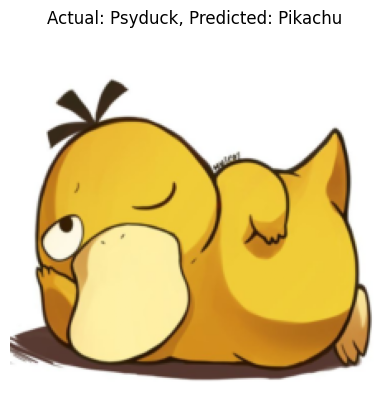

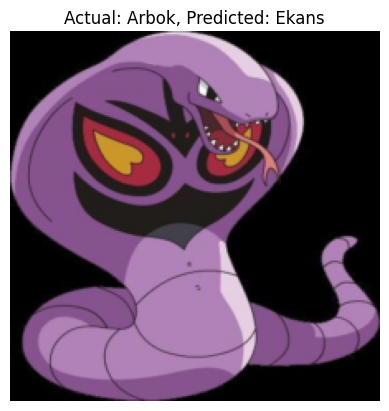

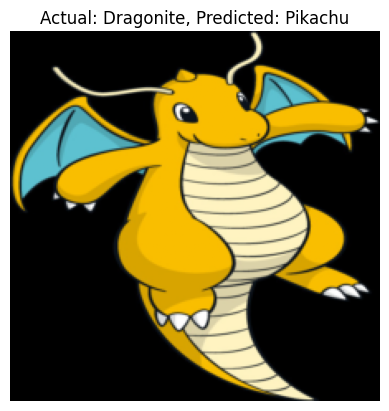

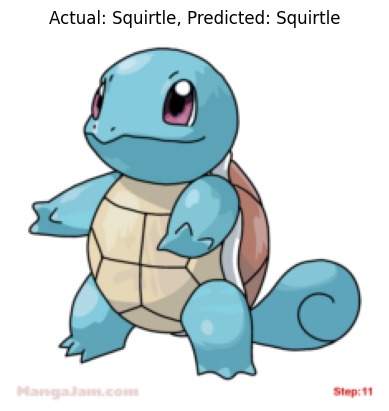

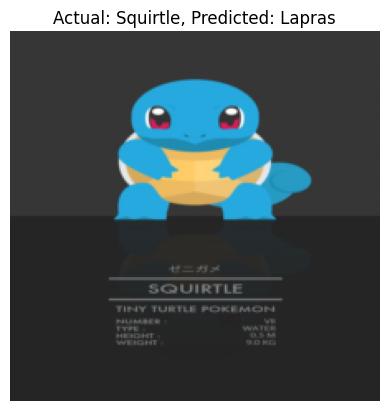

In [46]:
evaluate_and_visualize(model,test_loader=test_loader, dataset=dataset)